In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [42]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad=0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self._backward=lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other =other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=1.0*out.grad
            other.grad+= 1.0*out.grad
        
        out._backward=_backward
        return out

    def __neg__(self):
        return self*-1

    def __sub__(self,other):
        return self+ (-other)

    def __mul__(self,other):
        other =other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
            
        out._backward=_backward
        return out

    def __rmul__(self,other): #other * self
        return self*other

    def __truediv__(self,other): #self / other
        return self*other**-1

    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
            
        out._backward=_backward
        return out
        
    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supports int/float for powers"
        out=Value(self.data**other,(self,),f'**{other}')

        def _backward():
            self.grad+= other * (self.data**(other-1))*out.grad
            
        out._backward=_backward

        return out
        
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad+=out.data*out.grad
            
        out._backward=_backward

        return out

    def backward(self):
        topo=[]
        visited=set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2.0, label='f')
L=d*f;L.label='l'
L

Value(data=-8.0)

In [43]:
from graphviz import Digraph

def trace(root):
    nodes,edges=set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
                
def draw_dot(root, format='svg', rankdir='LR'):

    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s  | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [44]:
#input c1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights w1,w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias of the neuron
#the data is strange to make reading value of further calculation easier
b=Value(6.8813735870195432,label='b')

#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b;n.label='n'

o=n.tanh();o.label='o'
o.backward()

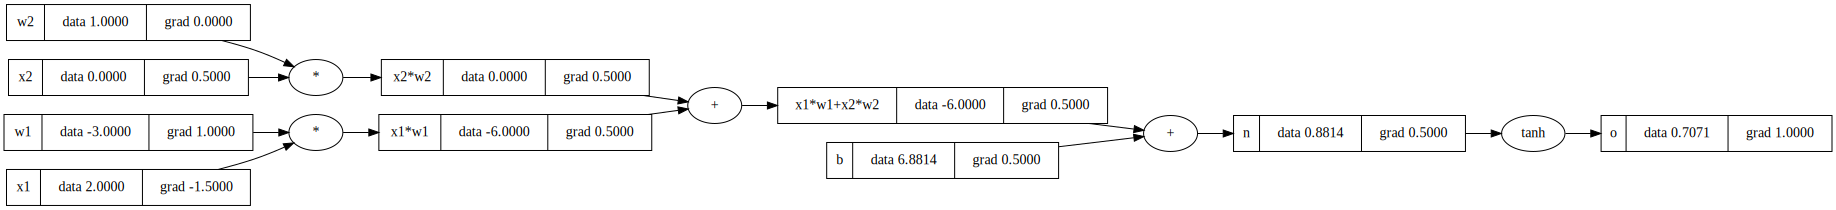

In [45]:
draw_dot(o)

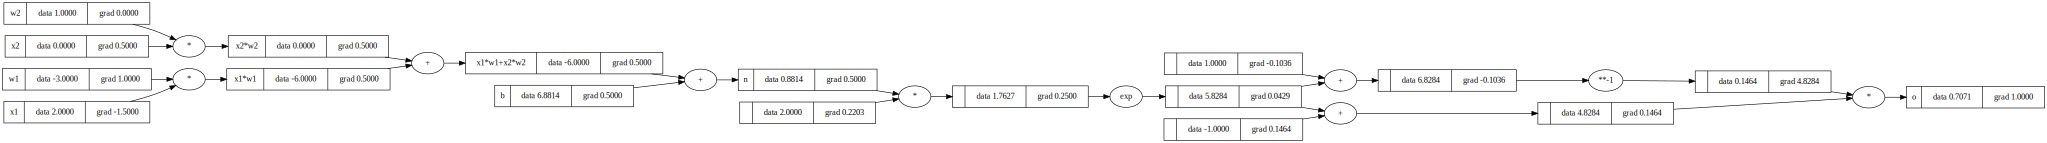

In [46]:
#input c1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#weights w1,w2
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

#bias of the neuron
#the data is strange to make reading value of further calculation easier
b=Value(6.8813735870195432,label='b')

#x1*w1+x2*w2+b
x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b;n.label='n'

e=(2*n).exp()
o=(e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [53]:
import torch

x1=torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2=torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1=torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2=torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b=torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n=x1*w1+x2*w2+b
o=torch.tanh(n)


print(o.data.item())
o.backward()

print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())




0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [56]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1)) 

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out=act.tanh()
        return out
        
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x



In [ ]:
x=[2.0,3,0,-1.0]
n=MLP(3,[4,4,1])

draw_dot(n(x))